<a href="https://colab.research.google.com/github/kareem1925/Ismailia-school-of-AI/blob/master/machine%20learning%20for%20classifying%20quantum%20states/Qiskit%20code%20for%20learning%20Q%20states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/Qiskit/qiskit-aqua.git -q

In [0]:
!pip install qiskit-aer qiskit-ignis qiskit-terra qiskit-ibmq-provider -q

In [0]:
import numpy as np
from qiskit import *
from qiskit import Aer
from qiskit.aqua.components.optimizers import *
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info.analysis import average_data,hellinger_fidelity
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua.utils import get_subsystem_density_matrix
from qiskit.tools.visualization import plot_histogram
np.set_printoptions(precision=15)
%matplotlib inline

In [4]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright


In [122]:
IBMQ.save_account('', overwrite=True)
provider = IBMQ.load_account()
provider.backends()
device_backend = provider.get_backend('ibmq_vigo')
coupling_map = device_backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(device_backend)
print(noise_model)
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

Credentials are already in use. The existing account in the session will be replaced.


NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2', 'u3', 'measure', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


In [0]:
def circuit(params):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q,c)
    #qc.h(q[0])
    
    qc.ry(params[0],q[0])
#    qc.rx(params[1],q[0])
    
    qc.cx(q[0],q[1])
    qc.snapshot('0')
    qc.measure(q[0],c[0])
    qc.measure(q[1],c[1])
    job = execute(qc, simulator, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,shots=10,backend_options={"max_parallel_threads":10}).result()
    
    statevector = np.array(job.data()['snapshots']['statevector']['0'][0])
    statevector = get_subsystem_density_matrix(statevector,[2,3,4])
    counts = job.get_counts()
    return counts, statevector


In [0]:
def cross_entropy(pred, targets, epsilon=1e-20):

    pred = np.clip(pred, epsilon, 1. - epsilon)
    
    n_samples = pred.shape[0]
    
    loss = -np.sum(targets*np.log10(pred+epsilon))/n_samples

    return loss

labels = np.array([0.5,0,0,0.5])
labels_vector = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
c = {'01': 0, '11': 50, '00': 50, '10': 0}

def cost(var):
    

#    print(var)
    st_vec = circuit(var)[1]

#    return cross_entropy(circuit(var),la)
    
    res = abs(1 - state_fidelity(st_vec,labels_vector))
#    res = - hellinger_fidelity(c,st_vec)
#    print(hellinger_fidelity(c,st_vec))

    return res

In [156]:
np.random.seed(5)
init_params = np.random.randn(1)
#init_params = [1.57079633]
print(init_params)
print(cost(init_params))

[2.57079633]
0.5679959683493738


In [0]:
opt = AQGD(disp=True,maxiter=100,tol=1e-16)
#opt = ADAM(tol=1e-11,lr=0.05)

In [158]:
opt.optimize(objective_function=cost,num_vars=1,initial_point=init_params)

Iteration: 0 	| Energy: 0.22984884841443087
Iteration: 1 	| Energy: 0.0007112573866856486
Iteration: 2 	| Energy: 0.12298848100841453
Iteration: 3 	| Energy: 0.07509163480584002
Iteration: 4 	| Energy: 0.0062996831237469575
Iteration: 5 	| Energy: 0.06520827289594189
Iteration: 6 	| Energy: 0.013061734790205337
Iteration: 7 	| Energy: 0.014558646433361133
Iteration: 8 	| Energy: 0.026277918198980066
Iteration: 9 	| Energy: 0.00020360190688462065
Iteration: 10 	| Energy: 0.012758881223493779
Iteration: 11 	| Energy: 0.006796589442922496
Iteration: 12 	| Energy: 0.0010814977037281182
Iteration: 13 	| Energy: 0.00678844919769217
Iteration: 14 	| Energy: 0.0007453649289186348
Iteration: 15 	| Energy: 0.0008659996926765334
Iteration: 16 	| Energy: 0.001511884874684788
Iteration: 17 	| Energy: 5.189269298155885e-06
Iteration: 18 	| Energy: 0.0007696328961306342
Iteration: 19 	| Energy: 0.000363455066797691
Iteration: 20 	| Energy: 7.89968337897573e-05
Iteration: 21 	| Energy: 0.0003941632446

(array([1.570796873664514]), 6.661338147750939e-16, 100)

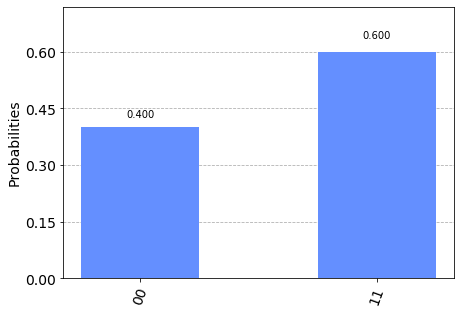

In [159]:
counts,density_matrix = circuit([1.570796873664514])
plot_histogram(counts)

In [160]:
print(state_fidelity(density_matrix,labels_vector))

0.9999999999999251
